In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor'] = 'black'

import sys
import math
import json
import re

hf = "/home"
sys.path.append(hf+"/will/projects/legoproj")
sys.path.append(hf+"/will/projects/training/dataprep")

import feature_utils as fu
from cvscripts import cv_utils as cvu

%matplotlib inline

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)

import keras
from keras.models import load_model


def getObjFromHue(hue,dset):
    hue = int(round(hue/5))
    name = dset["ids"][str(hue)]
    return name


def getObjectsData(dset):
    
    objsdata = {}
    for entry in dset["ids"]:

        if entry == "0":
            continue

        name = dset["ids"][entry]
        objentry = dset["objects"][name]

        #print(objentry)

        l2w = fu.matrix_from_string(objentry["modelmat"])
        w2l = np.linalg.inv(l2w)

        bbl = np.array(objentry["bbl"])
        bbh = np.array(objentry["bbh"])

        dims = bbh - bbl

        info = {}
        info["w2l"] = w2l
        info["lows"] = bbl

        info["dims"] = dims
        info["name"] = dset["ids"][entry]

        objsdata[name] = info
        
    return objsdata


def separate(mask):
    
    kernel = np.ones((2,2), np.uint8) 
    maskdict = {}

    hsvmask = cv2.cvtColor(mask,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsvmask],[0],None,[180],[0,179])
    
    hues=[]
    for j,e in enumerate(hist):
        if e[0] > 100:
            hues.append(j)

    for hue in hues:

        threshed = cv2.inRange(hsvmask, (hue-1,2,100), (hue+1,255,255))
        threshed = cv2.medianBlur(threshed.astype(np.uint8), 3)
        threshed = cv2.dilate(threshed, kernel, iterations=1)

        #if np.sum(threshed) <= 255*100:
            #continue;

        maskdict[hue] = threshed

    return maskdict


kernel = np.ones((3,3),np.uint8)

/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
mtx = np.load(hf+"/will/projects/legoproj/cvscripts/calib_data/" + "camins.npy")

std_model = load_model("/home/will/projects/legoproj/nets/tst_trueu_bayes.h5",compile=False)
wing_model = load_model("/home/will/projects/legoproj/nets/tst_trueu_bayes_wing.h5",compile=False)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [3]:
index = 6
datapath = "/home/will/projects/legoproj/data/kpts_dset_{}/".format(index)
data = fu.dictFromJson(datapath + "dset.json")

objsdata = getObjectsData(data)


def generatePrediction(i):

    tag = "{:0>4}".format(i)

    img = cv2.imread(datapath + "{}_a.png".format(tag))
    
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_in = cv2.resize(img_in,(256,256),interpolation=cv2.INTER_LINEAR)
    
    geomraw = cv2.imread(datapath + "geom/{}_geom.png".format(tag))
    geomrawwing = cv2.imread(datapath + "geom/{}_geom_wing.png".format(tag))

    pred = std_model.predict( np.reshape(img_in, (1,256,256,1)).astype('float32')/255.0 )
    pred = (255.0 * np.reshape((1.0+pred)/2.0, (256,256,4)))

    wingpred = wing_model.predict( np.reshape(img_in, (1,256,256,1)).astype('float32')/255.0 )
    wingpred = (255.0 * np.reshape((1.0+wingpred)/2.0, (256,256,4)))

    geom_pred = pred[:,:,0:3].astype(np.uint8)
    geom_pred_wing = wingpred[:,:,0:3].astype(np.uint8)

    maskpath = datapath + "{}_masks.png".format(tag)
    mask = cv2.imread(maskpath)
    masks = cvu.separate(mask)

    names = []

    for hue in masks:
        objname = getObjFromHue(hue,data)

        if objname:
            objclass = objname.split(".")[0]
            names.append(tuple([objname,hue]))
            
    return names, geom_pred, geom_pred_wing, cv2.cvtColor(img,cv2.COLOR_BGR2RGB), masks, geomraw, geomrawwing

WingR.002 with 1863 inliers (48%)
WingR.001 with 1158 inliers (33%)
Cockpit.001 with 421 inliers (85%)
Engine.002 with 1148 inliers (88%)


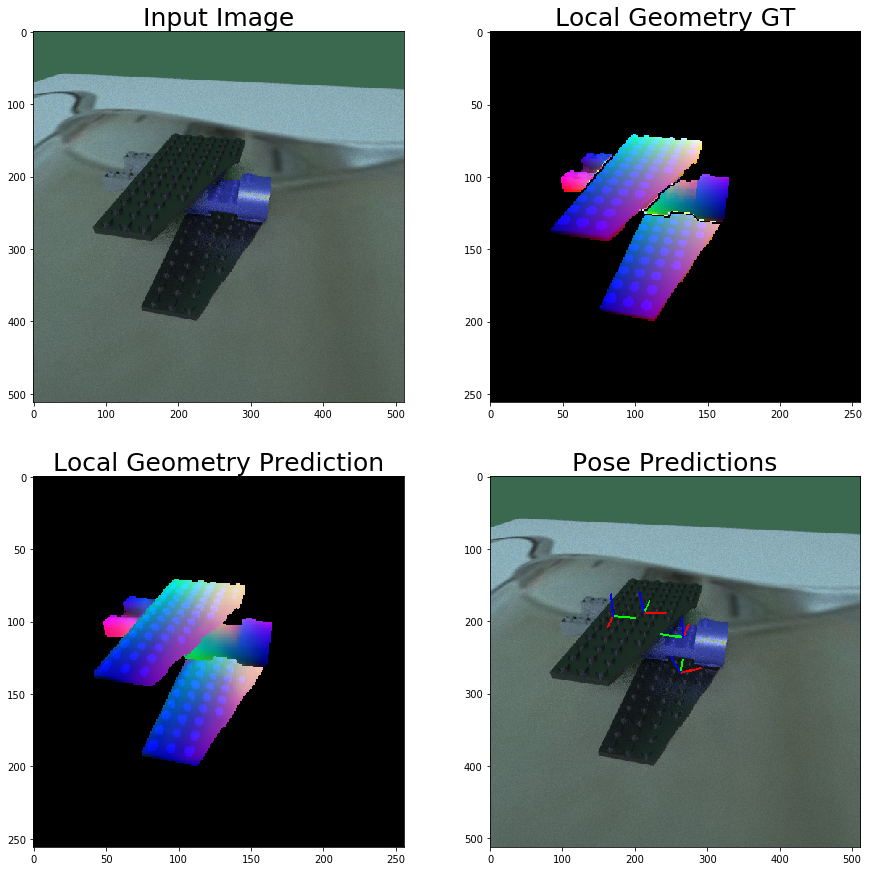

In [4]:
ind = 8
names, geom_pred, geom_pred_wing, img, masks, geomraw, geomrawwing = generatePrediction(ind)
imgdup = img.copy()
inds = np.dstack(np.meshgrid(np.arange(256), np.arange(256)))

geomcomp = np.zeros((256,256,3),dtype=np.uint8)
geomgtcomp = np.zeros((256,256,3),dtype=np.uint8)

for obj in names:
    
    name, hue = obj[0], obj[1]
    
    geompred = geom_pred
    geomgt = geomraw
        
    if "Wing" in name:
        geompred = geom_pred_wing
        geomgt = geomrawwing
   
    dims = objsdata[name]["dims"]
    bbl = objsdata[name]["lows"]
    
    objmask = cv2.resize(masks[hue], (256,256), cv2.INTER_LINEAR)
    #objmask = cv2.erode(objmask,kernel,iterations = 1)

    geompred = cv2.resize(geompred, (256,256), cv2.INTER_LINEAR)
    
    region = cv2.bitwise_and(geompred,geompred,mask=objmask)
    regiongt = cv2.bitwise_and(geomgt,geomgt,mask=objmask)
    
    thresh = objmask > 250
    
    geomcomp[thresh] = geompred[thresh]
    geomgtcomp[thresh] = geomgt[thresh]
    
    locs = 2*inds[thresh]
    locs = locs[:,0:2]

    coords = (bbl[2::-1] + dims[2::-1] * (region[thresh]/255))
    coords =  np.insert(coords[:,2::-1],3, 1.0, axis=-1) 
    coords = coords[:,0:3]

    
    ret, rvec, tvec, inliers = cv2.solvePnPRansac(coords.astype(np.float32), locs.astype(np.float32), mtx, None, flags=(cv2.SOLVEPNP_EPNP),reprojectionError=5,iterationsCount=1700)
    
    percentage = int(100 * len(inliers) / len(coords))
        
    print("{} with {} inliers ({}%)".format(name,len(inliers),percentage))
    
    axes, j1 = cv2.projectPoints(np.array([(0,0.0,0.0),(0.5, 0.0, 0.0),(0.0, 0.5, 0.0), (0.0, 0.0, 0.5)]), rvec, tvec, mtx, None)
    pt, j2 = cv2.projectPoints(coords.astype(np.float32), rvec, tvec, mtx, None)

    axes = np.array(axes,dtype=np.int32)[:,0,:]
    pt = np.array(pt,dtype=np.int32)[:,0,:]

    
    lines = [(255,0,0), (0,255,0), (0,0,255)]
    #for point in pt[::100]:
    #    cv2.circle(imgdup, (int(point[0]), int(point[1])), 5, (255, 255, 255), 1)

    obj_origin = tuple(axes[0])
    i = 0
    for point in axes[1:4]:
        cv2.line(imgdup, obj_origin, tuple(point), lines[i], 2)
        i+=1
    
    
        
    modelmat = fu.matrix_from_string(data["objects"][objname]["modelmat"])
    viewmat = fu.matrix_from_string(data["viewmats"][i])

    screenverts = fu.verts_to_screen(modelmat, viewmat, projmat, studs, filter=True)
    screenverts[:,0:2] = fu.toNDC(screenverts[:,0:2], (512,512))


fig=plt.figure(figsize=(15,15),facecolor='white')  
    
fig.add_subplot(2, 2, 1)
plt.title('Input Image', fontsize=25)
plt.imshow(img)

geomgtcomp = cv2.cvtColor(geomgtcomp, cv2.COLOR_BGR2RGB)

fig.add_subplot(2, 2, 2)
plt.title('Local Geometry GT', fontsize=25)
plt.imshow(geomgtcomp)

#geomcomp[geomgtcomp < 2] = geompred[geomgtcomp<2]
geomcomp = cv2.cvtColor(geomcomp, cv2.COLOR_BGR2RGB)

fig.add_subplot(2, 2, 3)
plt.title('Local Geometry Prediction', fontsize=25)
plt.imshow(geomcomp)

fig.add_subplot(2, 2, 4)
plt.title('Pose Predictions', fontsize=25)
plt.imshow(imgdup)
    
plt.show()

In [5]:
import scipy
from scipy.spatial.transform import Rotation as R
import inspect

tvec = np.array(tvec[:,0],dtype=np.float32) * np.array([1.0,-1.0,-1.0])
rvec = np.array(rvec[:,0],dtype=np.float32)

print("OpenCV tvec = {}".format( tvec ))

orig = np.array([0.0,0.0,0.0,1.0],dtype=np.float32)

mv = np.matmul(viewmat,modelmat)
camerapos = np.matmul(mv,orig)

#print("\nBlender camerapos mat = \n{}\n".format(mv))
print("Blender tvec = {}\n\n==============================================================".format(camerapos[0:3]))


#print("\nOpenCV rvec = {}\n\n".format( rvec ))

cvrotmat = R.from_rotvec(np.array(rvec,dtype=np.float32))

blenderrotmat = mv[0:3,0:3]
brotmat = R.from_matrix(blenderrotmat)

bl_euler = np.array(brotmat.as_euler('xyz', degrees=True),dtype=np.float32)
cv_euler = np.array(cvrotmat.as_euler('xyz', degrees=True),dtype=np.float32)

cv2bl = [1.0, -1.0, -1.0] * cv_euler + [180.0,0.0,0.0]

print("\nBlender rotmat = {}".format(bl_euler))
#print("OpenCV rotmat = \n{}\n".format(cv_euler))
print("Estimated rotmat = {}\n".format(cv2bl))

#print("Blender rotmat = \n{}\n".format(brotmat.as_rotvec()))
#print("OpenCV rotmat = \n{}\n".format(cvrotmat.as_rotvec()))


OpenCV tvec = [ 0.15921436  0.51985681 -6.00762224]


NameError: name 'viewmat' is not defined